In [1]:
import numpy as np
from cmt_vna import calkit as cal
from cmt_vna import VNA
import matplotlib.pyplot as plt
import os
%matplotlib widget

In [2]:
#fake freqs
fake_freqs = np.linspace(50e6, 250e6, 1001)

#Testing the calkit values. It's fine.
calkit = cal.S911T(freq_Hz = fake_freqs)

In [3]:
#testing that my polyval works
c_coefs = (6.18E-45, -226E-36, 2470E-27, -7.425E-15)
c_polyval = np.polyval(c_coefs, fake_freqs)
c_open = -7.425E-15 + 2470E-27 * fake_freqs - 226E-36 * fake_freqs**2 + 6.18E-45 * fake_freqs**3
assert np.allclose(c_open, c_polyval)

In [4]:
#testing that I can reproduce the gamma with c_open
c_delay = 30.821e-12 #s
c_loss = 2e9 #Ohm/s
Z0 = 50

Z_off_open = Z0 + (1-1j) * c_loss / (4 * np.pi * fake_freqs) * np.sqrt(fake_freqs/1e9)
gamma_off_open = cal.impedance_to_gamma(Z_off_open, Z0)
Z_ter_open = -1j / (2 * np.pi * fake_freqs * c_open)
gamma_ter_open = cal.impedance_to_gamma(Z_ter_open, Z0)

g_l_open = 1j * 2 * np.pi * fake_freqs * c_delay + (1+1j) * c_delay * c_loss / (2 * Z0) * np.sqrt(fake_freqs/1e9)

gamma_open = gamma_off_open * (1 - np.exp(-2 * g_l_open) - gamma_off_open * gamma_ter_open) + gamma_ter_open * np.exp(-2 * g_l_open)
gamma_open /= 1 - gamma_off_open * (np.exp(-2 * g_l_open) * gamma_off_open + gamma_ter_open * (1 - np.exp(-2 * g_l_open)))

assert np.allclose(calkit.open.gamma_ter, gamma_ter_open)
assert np.allclose(calkit.open.gamma_off, gamma_off_open)
assert np.allclose(calkit.open.gamma, gamma_open)

In [5]:
l_coefs = (-6.13E-42,303.8E-33, -5010E-24, 27.98E-12)
l_polyval = np.polyval(c_coefs, fake_freqs)
l_short = 27.98e-12 - 5010E-24 * fake_freqs + 303.8E-33 * fake_freqs**2 - 6.13E-42 * fake_freqs**3
assert np.allclose(l_short, l_polyval)

In [6]:
#testing I can reproduce gamma with l_short
l_delay = 30.688E-12 #s
l_loss = 2E9 #Ohm/s

Z_off_short = Z0 + (1-1j) * l_loss / (4 * np.pi * fake_freqs) * np.sqrt(fake_freqs/1e9)
gamma_off_short = cal.impedance_to_gamma(Z_off_short, Z0)
Z_ter_short = 1j * 2 * np.pi * fake_freqs * l_short
gamma_ter_short = cal.impedance_to_gamma(Z_ter_short, Z0)

g_l_short = 1j * 2 * np.pi * fake_freqs * l_delay + (1+1j) * l_delay * l_loss / (2 * Z0) * np.sqrt(fake_freqs/1e9)

gamma_short = gamma_off_short * (1 - np.exp(-2 * g_l_short) - gamma_off_short * gamma_ter_short) + gamma_ter_short * np.exp(-2 * g_l_short)
gamma_short /= 1 - gamma_off_short * (np.exp(-2 * g_l_short) * gamma_off_short + gamma_ter_short * (1 - np.exp(-2 * g_l_short)))

assert np.allclose(calkit.short.gamma_ter, gamma_ter_short)
assert np.allclose(calkit.short.gamma_off, gamma_off_short)
assert np.allclose(calkit.short.gamma, gamma_short)

# Now I know my standards work!
### That was deeply embarrassing actually.

Let's forget it happened and test to see if my sparams stuff makes sense.

If the measured standards are the same as the model standards, then my s params
should be perfecto, so that's first.

In [7]:
load_Z = 50 #Ohm
z_load = np.ones(len(fake_freqs)) * load_Z
gamma_load = cal.impedance_to_gamma(z_load, Z0)
fake_stds_meas = np.vstack([gamma_open, gamma_short, gamma_load])

test_sparams = calkit.sparams(stds_meas = fake_stds_meas)

assert np.allclose(fake_stds_meas, calkit.std_gamma) #standards are the same

In [8]:
s11 = test_sparams[0] #Should be 0
s12S21 = test_sparams[1] #Should be 1
s22 = test_sparams[2] #Should be 0

In [9]:
assert np.allclose(s11, 0)
assert np.allclose(s12S21, 1)
assert np.allclose(s22, 0)

# Given some S parameters...
Can I take a measured gamma and turn it into an intrinsic (de-embed)?
1. Measured gamma = models, sparams = perfect through => should get intrinsic = measured = models.

Can I take an intrinsic gamma and turn it into a measured gamma (embed)?
1. Intrinsic = models, sparams = perfect through => measured = models.
2. Intrinsic = models, sparams = stops => measured = 0.

Combine them!
1. Get a set of sparams! *The VNA ones I calculated*.
2. Embed the sparams into the model gammas. 
3. Can I get the right sparams out?
4. Can I get the model gammas back out of the embedded ones?

In [10]:
#Using fake_stds_meas for meas
###DE-EMBED PERFECT THRU SPARAMS###
Nfreq = len(fake_freqs)
thru_sparams = np.empty((3, Nfreq), dtype=complex)
thru_sparams[0] = 0 #S11
thru_sparams[1] = 1 #S12S21
thru_sparams[2] = 0 #S22

de_embedded_through_sparams = cal.de_embed_sparams(sparams=thru_sparams, gamma_prime=fake_stds_meas)
assert np.allclose(de_embedded_through_sparams, calkit.std_gamma)

In [11]:
###EMBED PERFECT THROUGH INTO MODEL PRMS###
embedded_thru_prms = cal.embed_sparams(sparams=thru_sparams, gamma=calkit.std_gamma)
assert np.allclose(embedded_thru_prms, fake_stds_meas)

###EMBED PERFECT STOP###
stop_sparams = np.empty((3, Nfreq), dtype=complex)
stop_sparams[0] = 1 #S11
stop_sparams[1] = 0 #S1221
stop_sparams[2] = 1 #S22

embedded_stop_prms = cal.embed_sparams(sparams=stop_sparams, gamma=calkit.std_gamma)
#This should be one across the board! Because it's a full stop
assert np.allclose(embedded_stop_prms, 1)

In [12]:
os.getcwd()

'/Users/cgtolley/Desktop/elsie/CMT-VNA/tests'

In [13]:
###COMBINE THE THINGS!###
#first, retrieve vna prms from model meas
DATA_DIR = '../data/unit_tests/'

CAL_DIR = os.path.join(DATA_DIR, 'cals')
CAL_FILE = os.path.join(CAL_DIR,'20250310_102048_calibration.npz')
CAL = np.load(CAL_FILE)
FREQS = CAL['freqs']
osl = np.vstack([CAL['open'], CAL['short'], CAL['load']])

calkit = cal.S911T(freq_Hz=FREQS) #new calkit with meas freqs

vna_sprms = cal.network_sparams(gamma_true=calkit.std_gamma, gamma_meas=osl) #vna_prms acquired

#embed now into models
test_meas = cal.embed_sparams(sparams=vna_sprms, gamma=calkit.std_gamma)

#Now we can take test_meas and std_gamma and try to get out the sparams again
retrieved_sprms = cal.network_sparams(gamma_true=calkit.std_gamma, gamma_meas = test_meas)
assert np.allclose(retrieved_sprms, vna_sprms)

#Now can take vna_sprms and osl and get the model out
retrieved_gamma_true = cal.de_embed_sparams(sparams=vna_sprms, gamma_prime=osl)
assert np.allclose(retrieved_gamma_true, calkit.std_gamma)

# Checking the loads
I put a 50 Ohm load across two differential signal paths. Here's what came out.

In [14]:
DATADIR = '../data/unit_tests/testing_0714/'

data_file = os.path.join(DATADIR, '20250411_101304_data.npz')
data = np.load(data_file)

# sprms_file = os.path.join(DATADIR, '20250411_100834_sparams.npz')
# sprms_data = np.load(sprms_file)

cable_file = os.path.join(DATADIR, '20250411_153033_data.npz')
cable_data = np.load(cable_file)

cals_at_vna = data['vna']
cals_at_cable = cable_data['cable']

load = data['20250411_101304_gamma']
freqs = data['freqs']

calkit = cal.S911T(freq_Hz=freqs)

/var/folders/cy/tyk8jd852vb0cz42dfbv8tvr0000gn/T/ipykernel_76197/3985680358.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(20*np.log10(np.abs(model_stds[2])), label='Load')


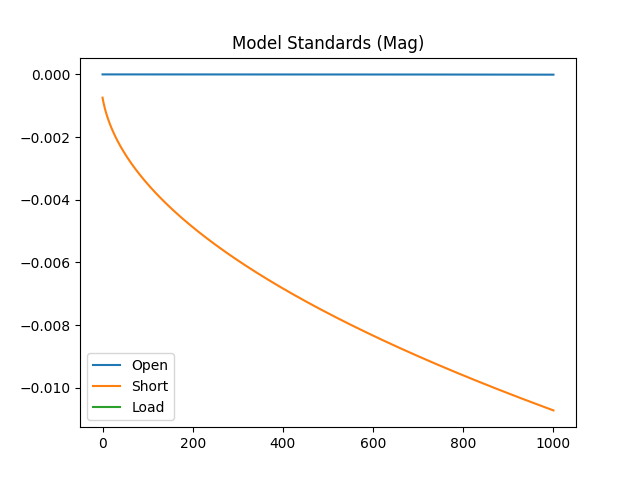

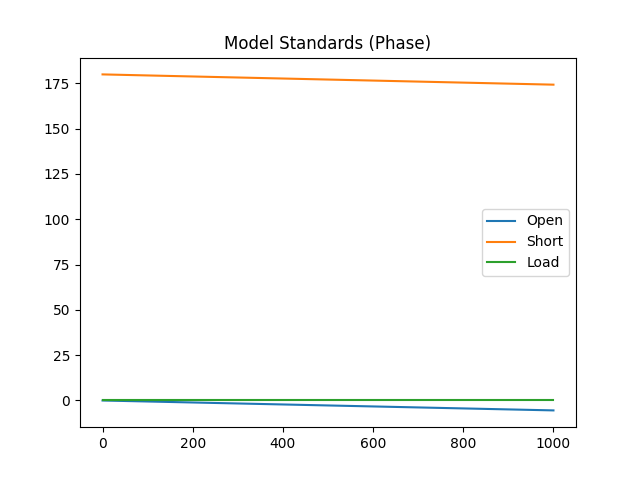

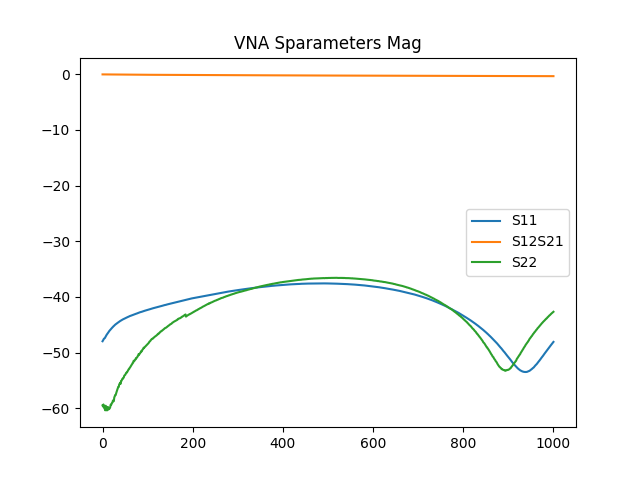

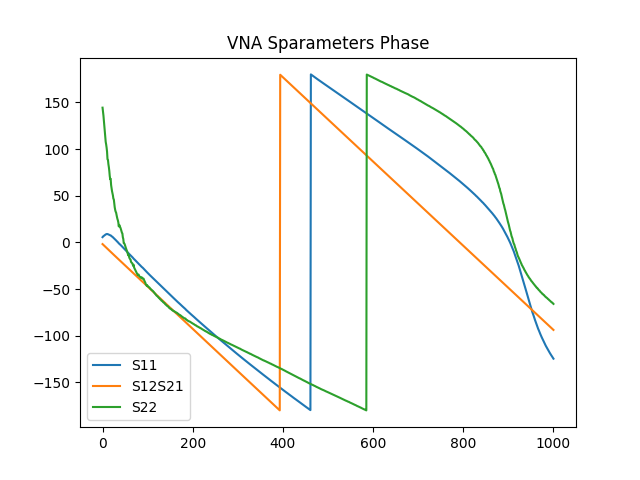

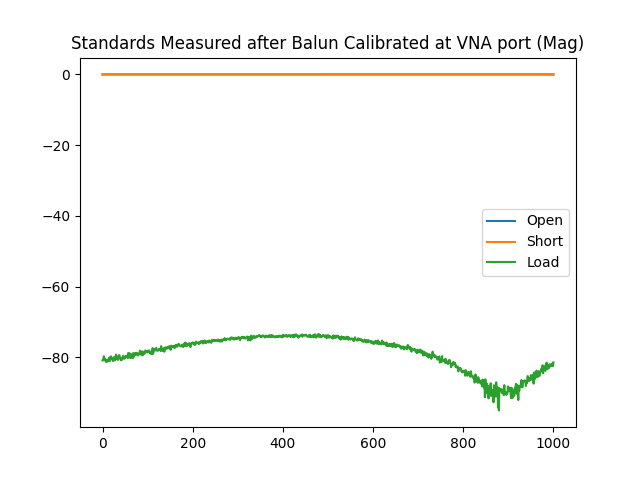

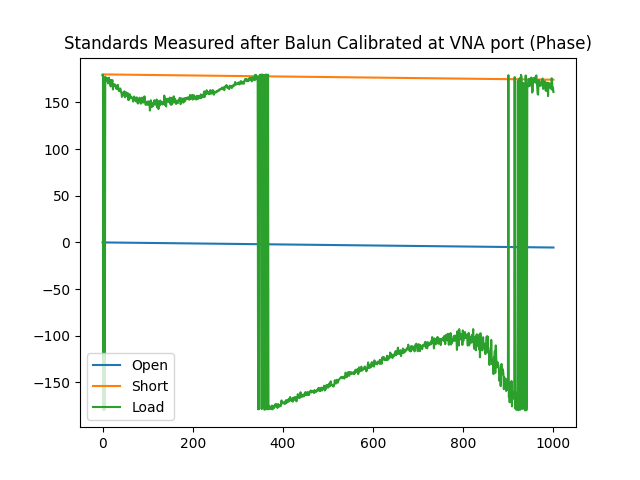

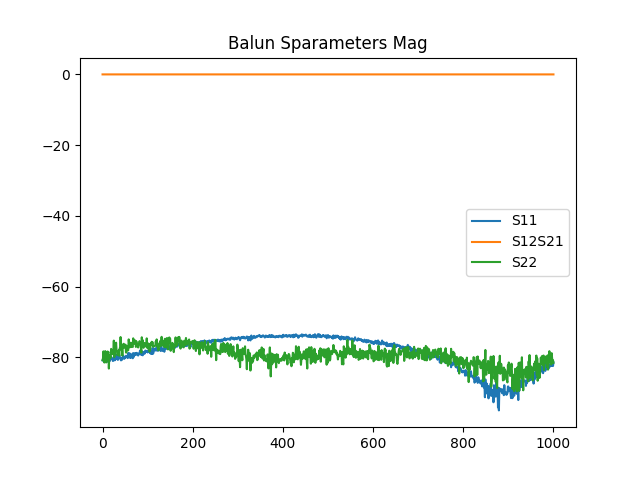

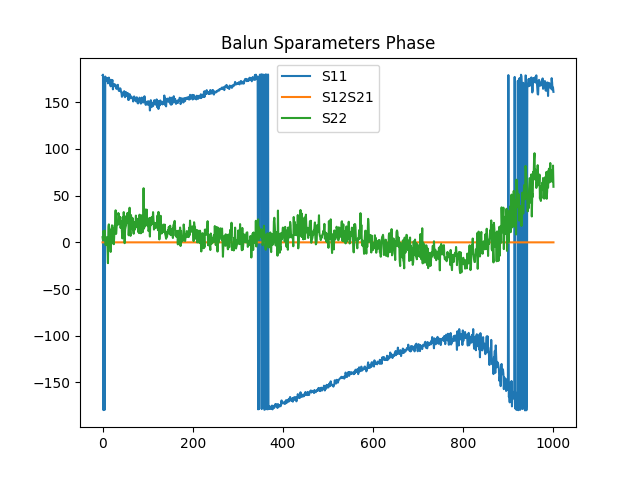

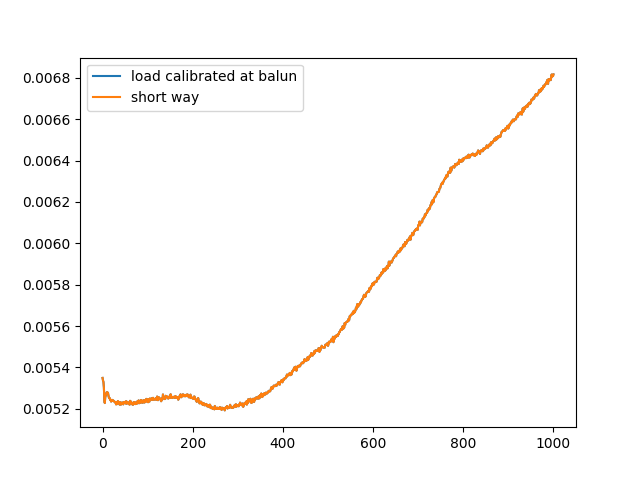

In [15]:
model_stds = calkit.std_gamma

plt.figure()
plt.plot(20*np.log10(np.abs(model_stds[0])), label='Open')
plt.plot(20*np.log10(np.abs(model_stds[1])), label='Short')
plt.plot(20*np.log10(np.abs(model_stds[2])), label='Load')
plt.legend()
plt.title('Model Standards (Mag)')
plt.show()

plt.figure()
plt.plot(np.angle(model_stds[0], deg=True), label='Open')
plt.plot(np.angle(model_stds[1], deg=True), label='Short')
plt.plot(np.angle(model_stds[2], deg=True), label='Load')

plt.legend()
plt.title('Model Standards (Phase)')
plt.show()

vna_sparams = cal.network_sparams(gamma_true=model_stds, gamma_meas=cals_at_vna)

plt.figure()
plt.plot(20*np.log10(np.abs(vna_sparams[0])), label='S11')
plt.plot(20*np.log10(np.abs(vna_sparams[1])), label='S12S21')
plt.plot(20*np.log10(np.abs(vna_sparams[2])), label='S22')
plt.legend()
plt.title('VNA Sparameters Mag')
plt.show()

plt.figure()
plt.plot(np.angle(vna_sparams[0], deg=True), label='S11')
plt.plot(np.angle(vna_sparams[1], deg=True), label='S12S21')
plt.plot(np.angle(vna_sparams[2], deg=True), label='S22')

plt.legend()
plt.title('VNA Sparameters Phase')
plt.show()

stds_after_cable_cal_at_vna = cal.de_embed_sparams(sparams=vna_sparams, gamma_prime=cals_at_cable)

plt.figure()
plt.plot(20*np.log10(np.abs(stds_after_cable_cal_at_vna[0])), label='Open')
plt.plot(20*np.log10(np.abs(stds_after_cable_cal_at_vna[1])), label='Short')
plt.plot(20*np.log10(np.abs(stds_after_cable_cal_at_vna[2])), label='Load')
plt.legend()
plt.title('Standards Measured after Balun Calibrated at VNA port (Mag)')
plt.show()

plt.figure()
plt.plot(np.angle(stds_after_cable_cal_at_vna[0], deg=True), label='Open')
plt.plot(np.angle(stds_after_cable_cal_at_vna[1], deg=True), label='Short')
plt.plot(np.angle(stds_after_cable_cal_at_vna[2], deg=True), label='Load')

plt.legend()
plt.title('Standards Measured after Balun Calibrated at VNA port (Phase)')
plt.show()
# plt.figure()
# plt.plot(np.angle(stds_after_balun_cal_at_vna[0], deg=True), label='S11')
# plt.plot(np.angle(stds_after_balun_cal_at_vna[1], deg=True), label='S12S21')
# plt.plot(np.angle(stds_after_balun_cal_at_vna[2], deg=True), label='S22')

# plt.legend()
# plt.title('VNA Sparameters Phase')
# plt.show()

cable_sprms = cal.network_sparams(gamma_true=model_stds, gamma_meas=stds_after_cable_cal_at_vna)

plt.figure()
plt.plot(20*np.log10(np.abs(cable_sprms[0])), label='S11')
plt.plot(20*np.log10(np.abs(cable_sprms[1])), label='S12S21')
plt.plot(20*np.log10(np.abs(cable_sprms[2])), label='S22')
plt.legend()
plt.title('Balun Sparameters Mag')
plt.show()

plt.figure()
plt.plot(np.angle(cable_sprms[0], deg=True), label='S11')
plt.plot(np.angle(cable_sprms[1], deg=True), label='S12S21')
plt.plot(np.angle(cable_sprms[2], deg=True), label='S22')

plt.legend()
plt.title('Balun Sparameters Phase')
plt.show()

#calibrate the load measurement now
load_at_vna = cal.de_embed_sparams(sparams=vna_sparams, gamma_prime=load)
load_at_cable_long_way = cal.de_embed_sparams(sparams=cable_sprms, gamma_prime=load_at_vna)

#calibrate load measurement short way
sprms_full_system = cal.network_sparams(gamma_true=model_stds, gamma_meas=cals_at_cable)

# plt.figure()
# plt.plot(np.abs(sprms_full_system[0]), label='S11')
# plt.plot(np.abs(sprms_full_system[1]), label='S12S21')
# plt.plot(np.abs(sprms_full_system[2]), label='S22')
# plt.legend()
# plt.title('Full System Sparameters')
# plt.show()

load_after_full_system = cal.de_embed_sparams(sparams=sprms_full_system, gamma_prime=load)

plt.figure()
# plt.plot(np.abs(load_at_vna), label='load calibrated at vna port')
plt.plot(np.abs(load_at_cable_long_way), label='load calibrated at balun')
plt.plot(np.abs(load_after_full_system), label='short way')
plt.legend()
plt.show()

In [16]:
sparams = {'vna':vna_sparams}
standards = {'vna':cals_at_vna, 'cable':cals_at_cable}

stds_after_cable_cal_at_vna_test = cal.calibrate(kit=calkit, gammas=standards['cable'], sprms_dict=sparams)

standards['cable_ref_vna'] = stds_after_cable_cal_at_vna_test

assert np.allclose(stds_after_cable_cal_at_vna, stds_after_cable_cal_at_vna_test)

cable_sprms_test = cal.network_sparams(gamma_true=model_stds, gamma_meas=standards['cable_ref_vna'])
sparams['cable'] = cable_sprms_test

assert np.allclose(cable_sprms_test, cable_sprms)

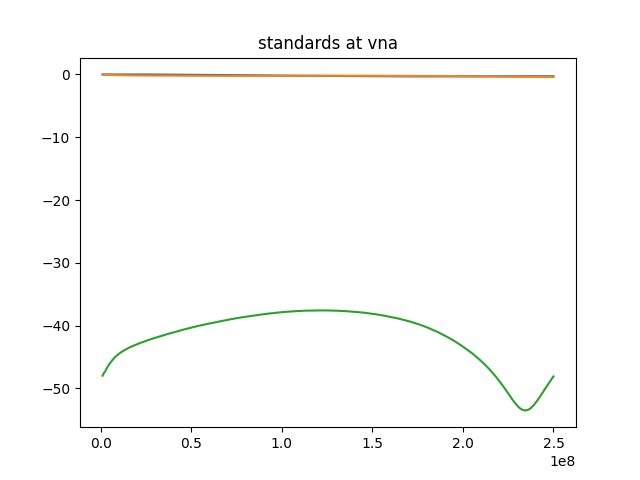

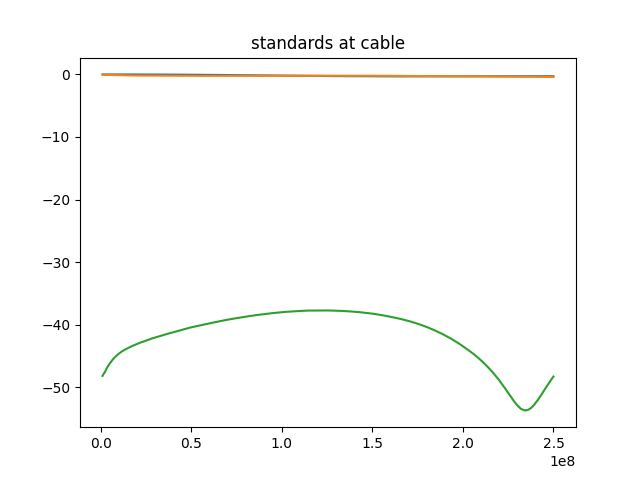

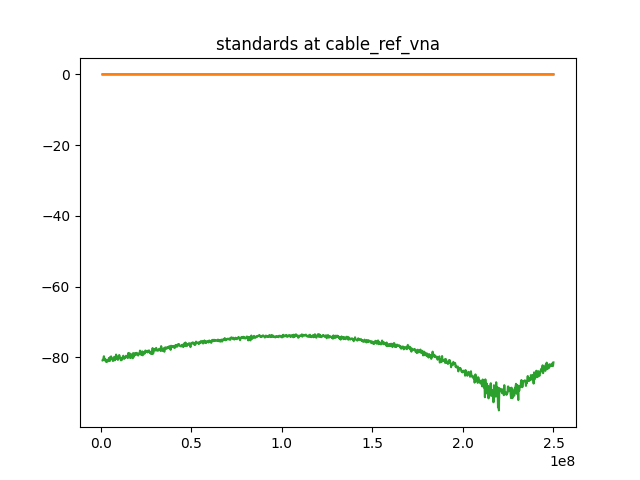

In [17]:
for key, data in standards.items():
    plt.figure()
    plt.plot(freqs, 20*np.log10(np.abs(data.T)))
    plt.title(f'standards at {key}')
    plt.show()

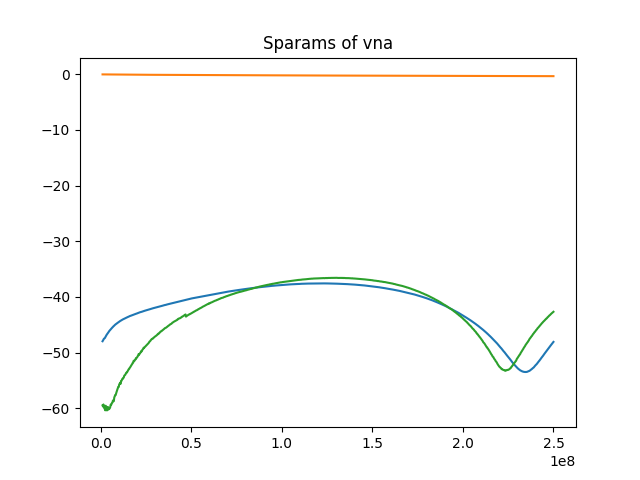

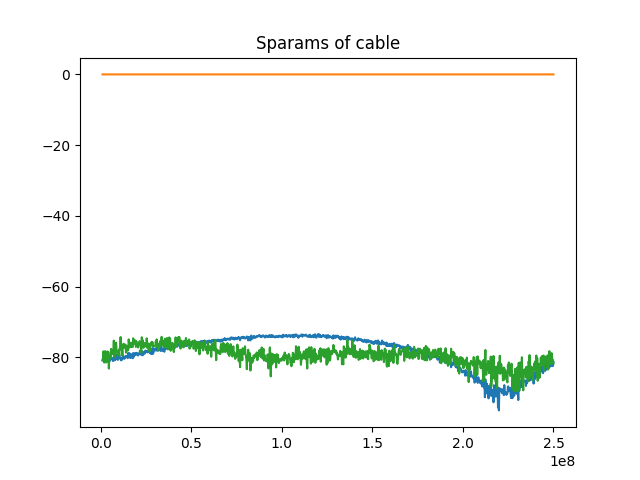

In [18]:
for key, data in sparams.items():
    plt.figure()
    plt.plot(freqs, 20*np.log10(np.abs(data.T)))
    plt.title(f'Sparams of {key}')
    plt.show()

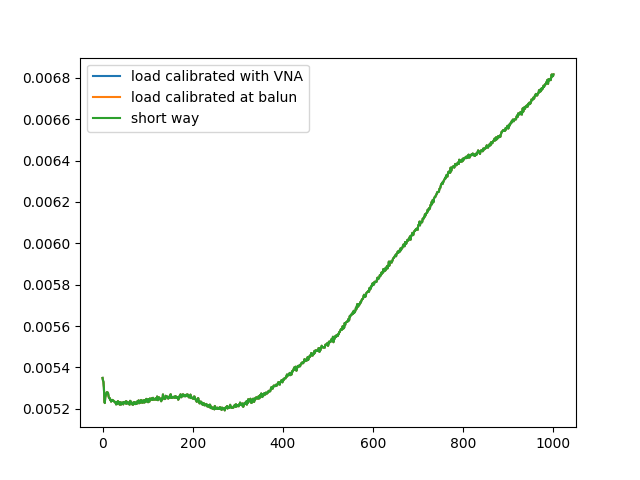

In [19]:
#gamma is load
load_cal = cal.calibrate(kit=calkit, gammas=load[np.newaxis, :], sprms_dict=sparams)
plt.figure()
plt.plot(np.abs(load_cal.T), label='load calibrated with VNA')
plt.plot(np.abs(load_at_cable_long_way), label='load calibrated at balun')
plt.plot(np.abs(load_after_full_system), label='short way')
plt.legend()
plt.show()

In [20]:
assert np.allclose(load_cal, load_at_cable_long_way)

# Make sure get_sparams works!

In [21]:
#sparams gives the sparams calculated by get_cable_sparams
#standards are in standards
sprms_file = os.path.join(DATADIR, '20250411_153033_sparams.npz')
sparams = np.load(sprms_file)

cable_file = os.path.join(DATADIR, '20250411_153033_data.npz')
standards = np.load(cable_file)

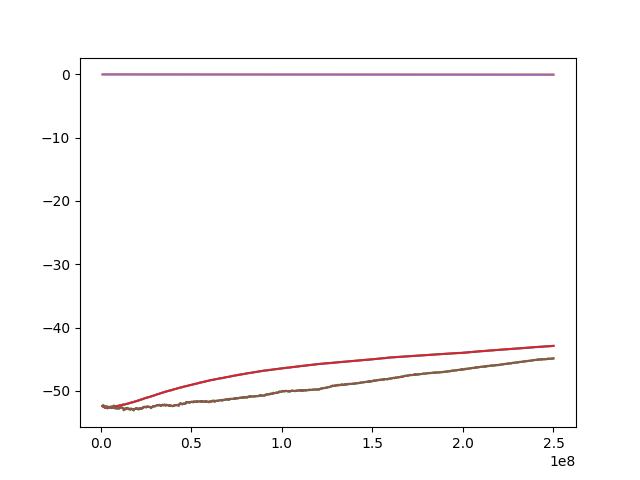

In [22]:
#Can I replicate the sparameters in sparams without my functions?
stds_at_vna = standards['vna']
stds_at_cable = standards['cable']

calkit = cal.S911T(freq_Hz=freqs)

vna_sprms = calkit.sparams(stds_meas=stds_at_vna)
test_vna_sprms = sparams['vna'] #what I got from the file
assert np.allclose(vna_sprms, test_vna_sprms)
#Plot the two sets of sparams
plt.figure()
plt.plot(freqs, 20*np.log10(np.abs(vna_sprms.T)))
# plt.show()
# plt.figure()
plt.plot(freqs, 20*np.log10(np.abs(test_vna_sprms.T)))
plt.show()

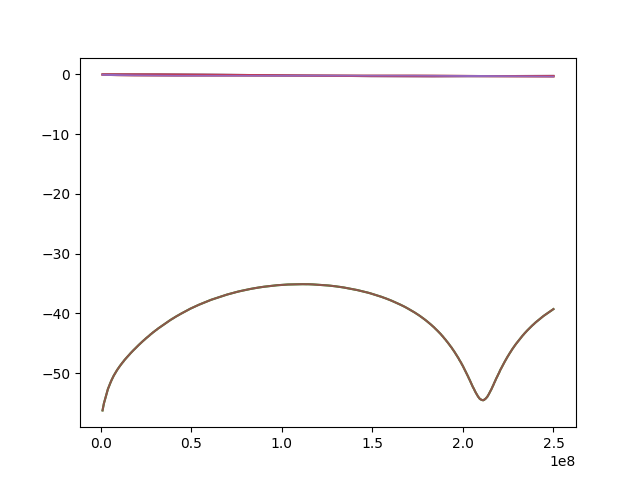

In [23]:
test_cable_stds_ref_vna = standards['cable_ref_vna']
cable_stds_ref_vna = cal.de_embed_sparams(sparams=sparams['vna'], gamma_prime=cals_at_cable)

assert np.allclose(cable_stds_ref_vna, test_cable_stds_ref_vna)
#Plot the two sets of sparams
plt.figure()
plt.plot(freqs, 20*np.log10(np.abs(cable_stds_ref_vna.T)))
plt.plot(freqs, 20*np.log10(np.abs(test_cable_stds_ref_vna.T)))
plt.show()

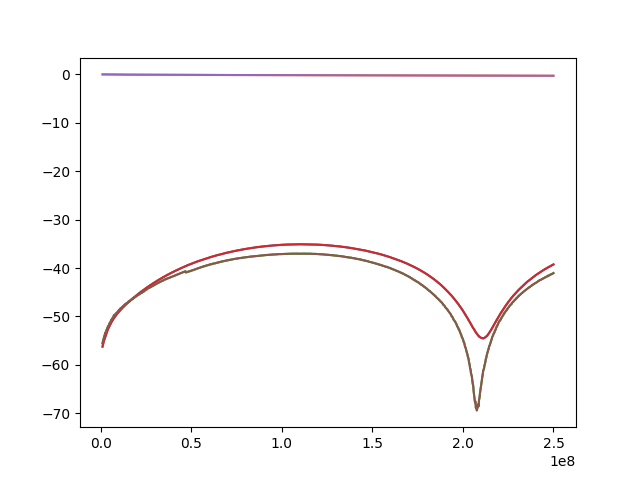

In [24]:
#The sprms of the cable now
cable_sprms = cal.network_sparams(gamma_true=calkit.std_gamma, gamma_meas=test_cable_stds_ref_vna)
test_cable_sprms = sparams['cable']
assert np.allclose(cable_sprms, test_cable_sprms)
#Plot the two sets of sparams
plt.figure()
plt.plot(freqs, 20*np.log10(np.abs(cable_sprms.T)))
# plt.show()
# plt.figure()
plt.plot(freqs, 20*np.log10(np.abs(test_cable_sprms.T)))
plt.show()